### Preprocessing Dataset & Model

In [2]:
import os
from typing import List, Tuple
import numpy as np
import librosa
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder

class RavdessDataset(Dataset):
    def __init__(self, data_dir: str, max_len: int = 250, n_mfcc: int = 40, sample_rate: int = 22050):
        """
        Initialize the dataset by providing the directory path of the dataset and 
        parameters for feature extraction and padding.

        Args:
            data_dir (str): Directory where the RAVDESS .wav files are stored.
            max_len (int): Maximum length of the audio features after padding/truncating. Default is 500.
            n_mfcc (int): Number of Mel-frequency cepstral coefficients (MFCCs) to extract. Default is 40.
            sample_rate (int): Sampling rate for loading the audio files. Default is 22050.
        """
        self.data_dir = data_dir
        self.max_len = max_len
        self.n_mfcc = n_mfcc
        self.sample_rate = sample_rate
        self.features, self.labels = self._load_and_process_data()
        self.encoder = LabelEncoder()
        self.labels = self.encoder.fit_transform(self.labels)
    
    def _load_and_process_data(self) -> Tuple[List[np.ndarray], List[str]]:
        """
        Loads the audio files from the dataset directory, extracts MFCC features, and pads/truncates them.

        Returns:
            Tuple containing a list of padded feature arrays and a list of labels.
        """
        features, labels = [], []

        # Loop through all files in the dataset directory
        for file_name in os.listdir(self.data_dir):
            if file_name.endswith('.wav'):
                file_path = os.path.join(self.data_dir, file_name)

                # Load the audio file
                audio, sr = self._load_audio_file(file_path)

                # Extract MFCC features
                mfcc = self._extract_mfcc(audio, sr)

                # Pad or truncate the MFCCs to the max length
                mfcc_padded = self._pad_features(mfcc, self.max_len)

                # Extract label from filename (assuming filenames follow a naming convention)
                label = self._extract_label(file_name)

                # Append the processed features and label
                features.append(mfcc_padded)
                labels.append(label)

        return features, labels

    def _load_audio_file(self, file_path: str) -> Tuple[np.ndarray, int]:
        """
        Load an audio file using librosa.

        Args:
            file_path (str): Path to the audio file.

        Returns:
            Tuple containing the audio signal (numpy array) and its sampling rate (int).
        """
        audio, sr = librosa.load(file_path, sr=self.sample_rate)
        return audio, sr

    def _extract_mfcc(self, audio: np.ndarray, sample_rate: int) -> np.ndarray:
        """
        Extract MFCC features from an audio signal.

        Args:
            audio (np.ndarray): The audio signal.
            sample_rate (int): The sampling rate of the audio.

        Returns:
            np.ndarray: The MFCC feature matrix.
        """
        return librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=self.n_mfcc)

    def _pad_features(self, features: np.ndarray, max_len: int) -> np.ndarray:
        """
        Pad or truncate the MFCC features to a fixed length.

        Args:
            features (np.ndarray): MFCC feature matrix.
            max_len (int): The desired maximum length for padding/truncating.

        Returns:
            np.ndarray: The padded or truncated feature matrix.
        """
        if features.shape[1] < max_len:
            pad_width = max_len - features.shape[1]
            padded_features = np.pad(features, ((0, 0), (0, pad_width)), mode='constant')
        else:
            padded_features = features[:, :max_len]
        
        return padded_features

    def _extract_label(self, file_name: str) -> str:
        """
        Extract the emotion label from the filename. Assumes the label is in the third part of the filename,
        separated by dashes (e.g., '03-01-05-02.wav').

        Args:
            file_name (str): Name of the audio file.

        Returns:
            str: The extracted label.
        """
        return file_name.split('-')[2]

    def __len__(self) -> int:
        """
        Return the total number of samples in the dataset.

        Returns:
            int: The number of samples.
        """
        return len(self.features)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        """
        Get the sample at index `idx`.

        Args:
            idx (int): Index of the sample to fetch.

        Returns:
            Tuple containing the feature tensor and the corresponding label.
        """
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label


In [3]:
import torch
import torch.nn as nn

class EmotionRecognitionModel(nn.Module):
    def __init__(self, num_classes: int):
        """
        A Convolutional Neural Network (CNN) for emotion recognition from MFCC features.

        Args:
            num_classes (int): The number of output classes (emotions).
        """
        super(EmotionRecognitionModel, self).__init__()
        
        # Feature extractor (convolutional layers)
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        
        # Fully connected layers (adjusted to match the new feature map size)
        self.classifier = nn.Sequential(
            nn.Linear(3584, 256),  # Flattened size, adjust depending on input size and pooling
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the model.
        
        Args:
            x (torch.Tensor): The input tensor (MFCC features).

        Returns:
            torch.Tensor: The output tensor (logits for each class).
        """

        x = self.features(x)
        
        # Flatten the tensor before passing it into the classifier
        x = x.view(x.size(0), -1)
        
        x = self.classifier(x)
        
        return x
    
    def get_activation_maps(self, x: torch.Tensor) -> torch.Tensor:
        """
        Get the activation maps from the last convolutional layer.

        Args:
            x (torch.Tensor): Input tensor.

        Returns:
            torch.Tensor: Activation maps from the last convolutional layer.
        """
        x = self.features[0](x)  # Apply first conv layer
        x = self.features[1](x)  # Apply ReLU
        x = self.features[2](x)  # Apply MaxPool
        
        x = self.features[3](x)  # Apply second conv layer
        x = self.features[4](x)  # Apply ReLU
        x = self.features[5](x)  # Apply MaxPool
        
        x = self.features[6](x)  # Apply third conv layer
        x = self.features[7](x)  # Apply ReLU
        x = self.features[8](x)  # Apply MaxPool
        
        return x


In [4]:
from torch.utils.data import DataLoader

# Initialize the dataset
dataset = RavdessDataset(data_dir='../data/all_ravdess_files/', max_len=250, n_mfcc=40)

from torch.utils.data import DataLoader, random_split

# Assuming `ravdess_dataset` is already loaded

# Get dataset lengths for the 60-20-20 split
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

# Randomly split the dataset into train, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### Training

Epoch [1/20], Train Loss: 2.2376, Train Accuracy: 11.81%
Epoch [1/20], Validation Loss: 2.0217, Validation Accuracy: 18.40%
Epoch [2/20], Train Loss: 2.0306, Train Accuracy: 15.97%
Epoch [2/20], Validation Loss: 1.9714, Validation Accuracy: 23.26%
Epoch [3/20], Train Loss: 1.9940, Train Accuracy: 19.44%
Epoch [3/20], Validation Loss: 1.9309, Validation Accuracy: 23.61%
Epoch [4/20], Train Loss: 1.9550, Train Accuracy: 23.03%
Epoch [4/20], Validation Loss: 1.8542, Validation Accuracy: 28.82%
Epoch [5/20], Train Loss: 1.8496, Train Accuracy: 26.27%
Epoch [5/20], Validation Loss: 1.6482, Validation Accuracy: 35.07%
Epoch [6/20], Train Loss: 1.8052, Train Accuracy: 29.28%
Epoch [6/20], Validation Loss: 1.6209, Validation Accuracy: 35.42%
Epoch [7/20], Train Loss: 1.7638, Train Accuracy: 31.02%
Epoch [7/20], Validation Loss: 1.6047, Validation Accuracy: 37.85%
Epoch [8/20], Train Loss: 1.6590, Train Accuracy: 36.00%
Epoch [8/20], Validation Loss: 1.5212, Validation Accuracy: 43.75%
Epoch [9

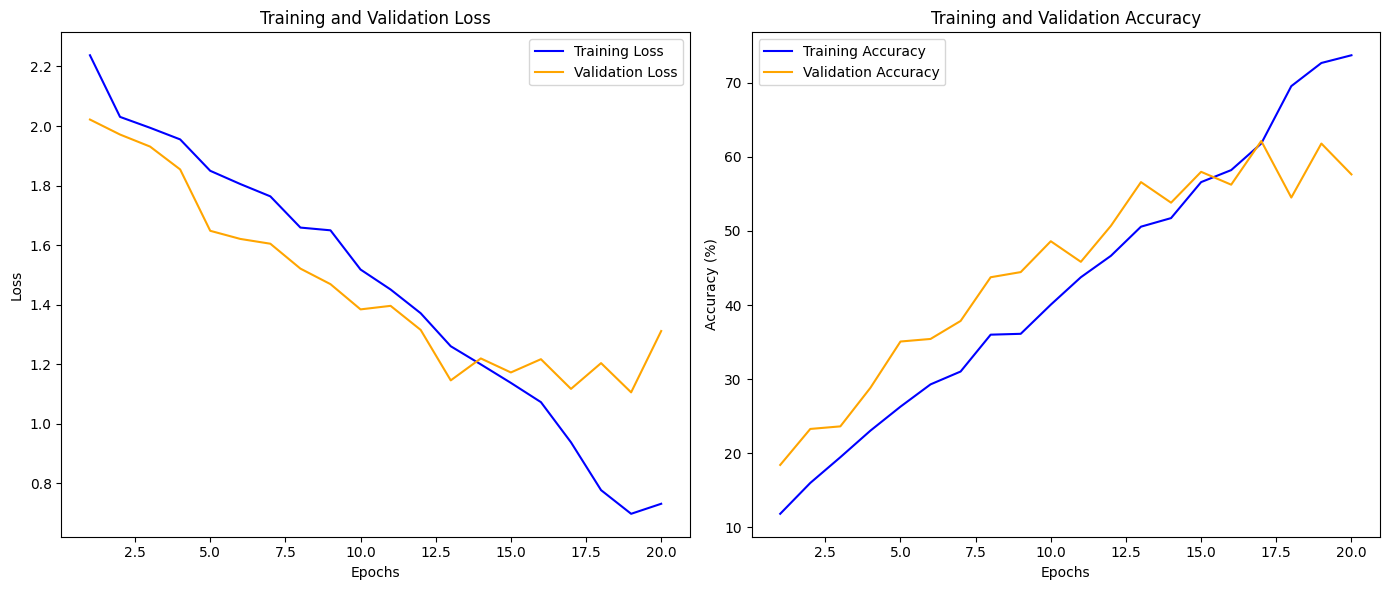

In [5]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# Initialize lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Set device (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
num_classes = 8  # Number of emotion classes in the RAVDESS dataset
learning_rate = 0.001
batch_size = 32
num_epochs = 20

# Initialize the model, loss function, and optimizer
model = EmotionRecognitionModel(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with validation
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training phase
    for data, labels in train_loader:
        data, labels = data.to(device), labels.to(device)
        
        # Add channel dimension
        data = data.unsqueeze(1)  # [batch_size, 1, 40, 250]
        
        outputs = model(data)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_train_loss += loss.item()
        
        # Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    
    # Save training metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(device), labels.to(device)
            
            # Add channel dimension
            data = data.unsqueeze(1)
            
            outputs = model(data)
            loss = criterion(outputs, labels)
            
            running_val_loss += loss.item()
            
            # Accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    
    # Save validation metrics
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

# Testing phase (after all epochs)
model.eval()
running_test_loss = 0.0
correct_test = 0
total_test = 0

with torch.no_grad():
    for data, labels in test_loader:
        data, labels = data.to(device), labels.to(device)
        
        # Add channel dimension
        data = data.unsqueeze(1)
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, labels)
        
        running_test_loss += loss.item()
        
        # Accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

avg_test_loss = running_test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test
print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

# Plotting training, validation, and test metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 6))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### SHAP and Plots

In [6]:
import shap
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader, random_split

# Load the dataset
ravdess_dataset = RavdessDataset(data_dir="../data/all_ravdess_files")

# Split into train and test sets
train_size = int(0.8 * len(ravdess_dataset))
test_size = len(ravdess_dataset) - train_size
train_dataset, test_dataset = random_split(ravdess_dataset, [train_size, test_size])

# Create DataLoader for train and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

/home/andrea-coppari/XAI/XAINT/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


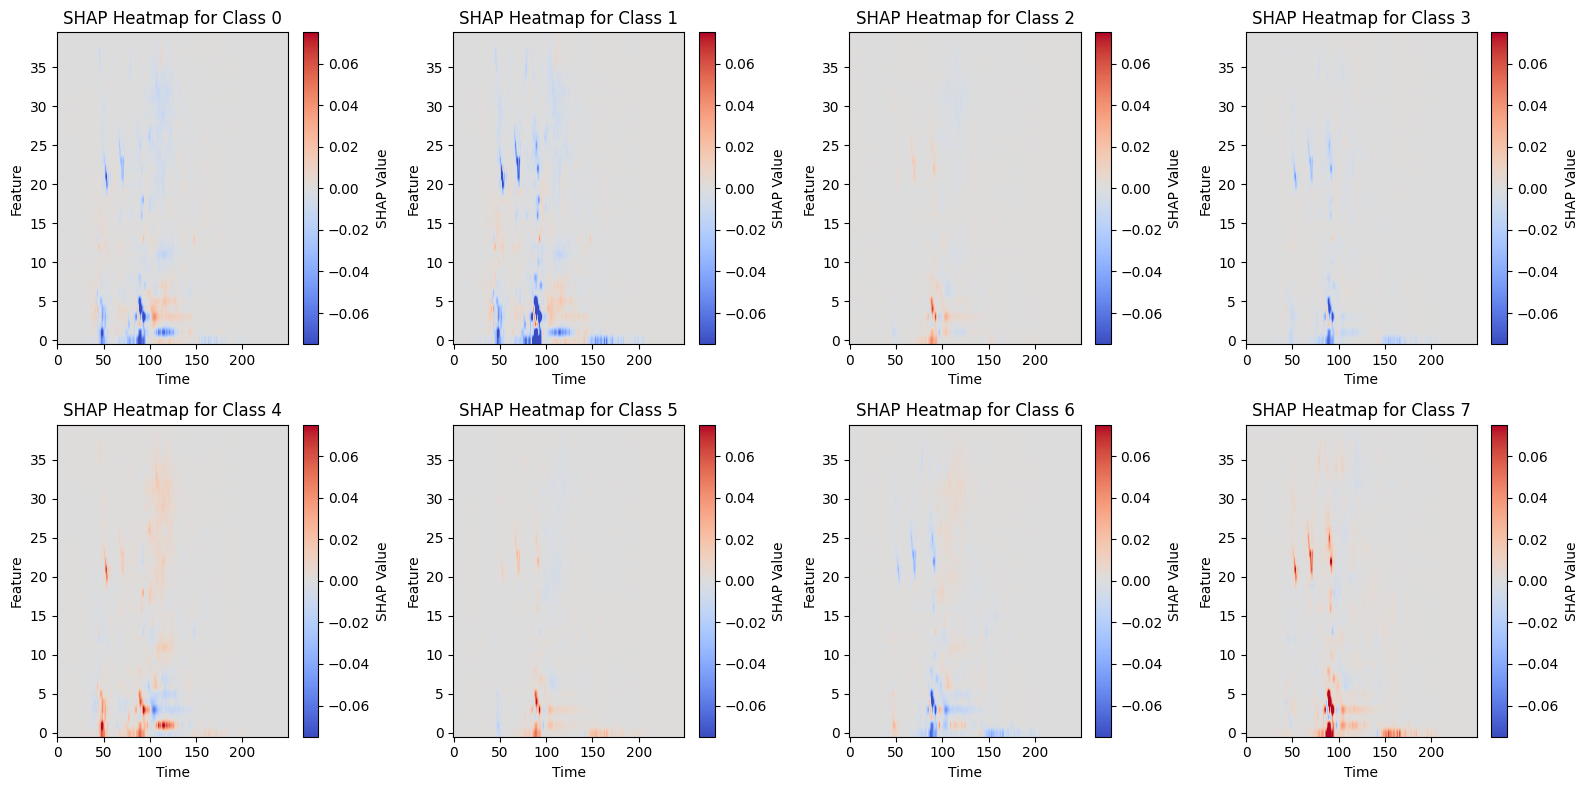

In [22]:
# Ensure the model is in evaluation mode
model.eval()

# Extract a subset of data from the train_loader to use as background for SHAP
background_data = []
for i, (data, labels) in enumerate(train_loader):
    if len(background_data) >= 100:  # Use 100 samples as background data
        break
    # Add the channel dimension
    data = data.unsqueeze(1)  # Shape: [batch_size, 1, 40, 500]
    background_data.append(data)
    
# Concatenate the list of tensors into one tensor
background = torch.cat(background_data, dim=0)[:100]  # Use exactly 100 samples

# Initialize the SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background)

# Select a sample input from the test_loader
sample_input, _ = next(iter(test_loader))  # Take the first batch from the test_loader
sample_input = sample_input[0].unsqueeze(0).unsqueeze(0)  # Select a single sample, add channel and batch dimensions

# Compute SHAP values
shap_values = explainer.shap_values(sample_input)

# Convert SHAP values to numpy array
shap_values_numpy = np.array(shap_values[0])  # Shape should be (1, 40, 500, 8)

# Convert sample_input to numpy and squeeze extra dimensions
sample_input_numpy = sample_input.squeeze().detach().cpu().numpy()  # Shape: [40, 500]

# Plotting the original waveform and the heatmaps for all classes
plt.figure(figsize=(16, 8))  # Adjust the figure size for 2 rows and 4 columns

# # Plot the original waveform
# plt.subplot(2, 4, 1)
# plt.plot(sample_input_numpy.flatten(), label='Original Audio Waveform')
# plt.title('Original Audio Waveform')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')

# Plot SHAP heatmaps for each class in a 2x4 grid
num_classes = 8
for class_index in range(num_classes):
    plt.subplot(2, 4, class_index + 1)  # Start subplots from (2, 4, 1)
    shap_values_class = shap_values_numpy[0, :, :, class_index]  # Shape: [40, 500]
    plt.imshow(shap_values_class, aspect='auto', cmap='coolwarm', origin='lower', vmin=-0.075, vmax=0.075)
    plt.colorbar(label='SHAP Value')
    plt.title(f'SHAP Heatmap for Class {class_index}')
    plt.xlabel('Time')
    plt.ylabel('Feature')

plt.tight_layout()
plt.show()

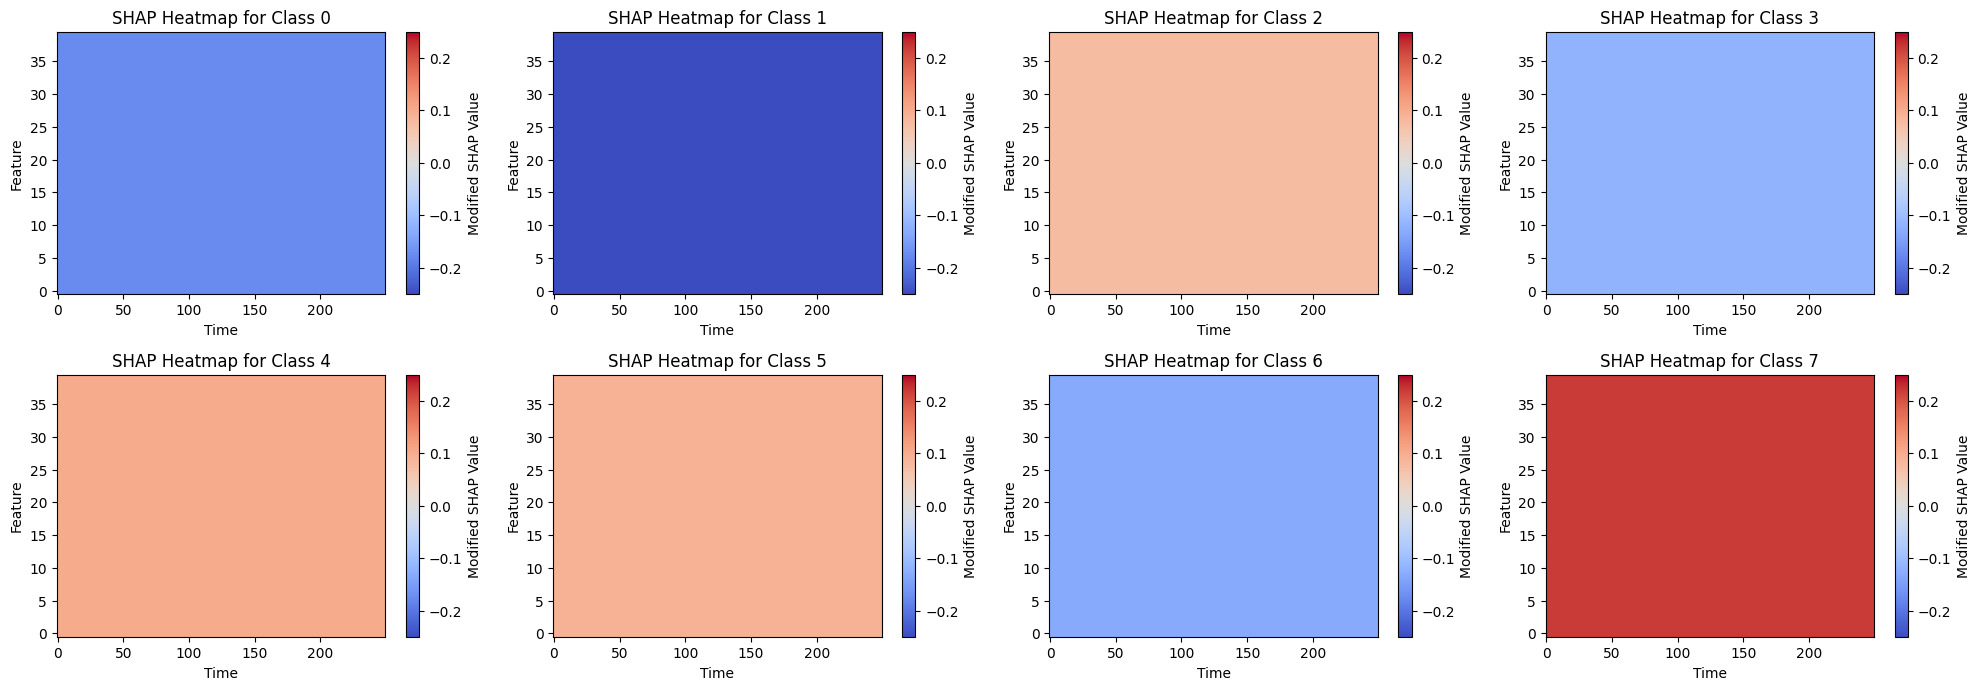

In [21]:
# Select a sample input from the test_loader
sample_input, _ = next(iter(test_loader))  # Take the first batch from the test_loader
sample_input = sample_input[0].unsqueeze(0).unsqueeze(0)  # Select a single sample, add channel and batch dimensions

# Compute SHAP values
shap_values = explainer.shap_values(sample_input)

# Convert SHAP values to numpy array
shap_values_numpy = np.array(shap_values[0])  # Shape should be (1, 40, 500, 8)

# The number of classes and the shape of the matrix
num_classes = shap_values_numpy.shape[-1]
matrix_shape = shap_values_numpy.shape[1:3]  # Shape: (40, 500)

# Process each class individually to determine if we use top 3 max or min values
modified_shap_values = np.zeros((num_classes, *matrix_shape))

for class_index in range(num_classes):
    # Extract SHAP values for the current class
    shap_values_class = shap_values_numpy[0, :, :, class_index]
    
    # Flatten the SHAP values for easier sorting
    flat_shap_values = shap_values_class.flatten()
    
    # Get the top 3 maximum and minimum values
    top3_max = np.sort(flat_shap_values)[-3:]  # Top 3 maximum values
    top3_min = np.sort(flat_shap_values)[:3]   # Top 3 minimum values
    
    # Compare the absolute sum of top 3 max vs top 3 min
    if abs(np.sum(top3_max)) > abs(np.sum(top3_min)):
        # Fill the matrix with the maximum of the top 3 max values
        modified_shap_values[class_index] = np.full(matrix_shape, np.max(top3_max))
    else:
        # Fill the matrix with the minimum of the top 3 min values
        modified_shap_values[class_index] = np.full(matrix_shape, np.min(top3_min))

# Plotting the original waveform and the modified SHAP heatmaps
plt.figure(figsize=(20, 10))

# # Plot the original waveform
# plt.subplot(3, 4, 1)
# plt.plot(sample_input.squeeze().detach().cpu().numpy().flatten(), label='Original Audio Waveform')
# plt.title('Original Audio Waveform')
# plt.xlabel('Time')
# plt.ylabel('Amplitude')

# Plot the modified SHAP heatmaps for each class
for class_index in range(num_classes):
    plt.subplot(3, 4, class_index + 1)
    plt.imshow(modified_shap_values[class_index], aspect='auto', cmap='coolwarm', origin='lower', vmin=-0.25, vmax=0.25)
    plt.colorbar(label='Modified SHAP Value')
    plt.title(f'SHAP Heatmap for Class {class_index}')
    plt.xlabel('Time')
    plt.ylabel('Feature')

plt.tight_layout()
plt.show()

In [112]:
import torch
import shap

import torch.nn as nn
import torch.nn.init as init
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from PIL import Image
from tqdm import tqdm
from io import BytesIO
from typing import List

import tempfile
import os


class XAINT(nn.Module):
    """
    XAINT (eXplainable Ai through Iterative Network Truncation) is a PyTorch neural network module that creates a truncated version of a given AI model.
    It retains the first k layers from the original model and attaches an adjustment layer to align 
    the output dimensions with the classifier layer of the original model.

    Parameters:
    ----------
    model : EmotionRecognitionModel
        The original model from which to truncate the layers.
    k : int
        The number of layers to remove from the original model's hidden layers. The layers are truncated
        from the end of the hidden layers.

    Attributes:
    ----------
    truncated_model : nn.Sequential
        A sequential container of the first k hidden layers from the original model.
    classifier : nn.Sequential
        The classifier layer from the original model.
    adjust_layer : nn.Linear or nn.Identity
        A linear layer that adjusts the output size from the truncated model to match the input size
        of the classifier. If the sizes are already compatible, this is an identity layer.

    Methods:
    -------
    forward(x: Tensor) -> Tensor
        Performs a forward pass of the input tensor through the truncated model, adjustment layer,
        and classifier.

    Notes:
    -----
    - If the number of layers to be kept (k) is such that the dimensions between the truncated output
      and the classifier input are different, an adjustment layer is added and initialized using
      Xavier uniform initialization.
    - Weights for both the truncated model and classifier are copied from the original model to ensure
      consistency.
    """
    def __init__(self, model: EmotionRecognitionModel, k: int):
        """
        Initializes the XAINT class by truncating the given MLP model and setting up the necessary
        adjustment layer.

        Parameters:
        ----------
        model : EmotionRecognitionModel
            The original EmotionRecognitionModel model to truncate.
        k : int
            The number of layers to remove from the original model's hidden layers.
        """
        super(XAINT, self).__init__()

        # number of layers to keep
        k = len(model.features)-k*3

        self.truncated_model = nn.Sequential(*list(model.features.children())[:k])
        self.classifier = model.classifier

        dummy_input = torch.randn(1, 1, 40, 250)  # [batch_size, channels, height, width]
        with torch.no_grad():
            truncated_output = self.truncated_model(dummy_input)

        # Calculate the flattened output size for the adjustment layer
        truncated_output_size = truncated_output.view(1, -1).size(1)
        classifier_input_size = model.classifier[0].in_features

        # Create an adjustment layer if the sizes do not match
        if truncated_output_size != classifier_input_size:
            self.adjust_layer = nn.Linear(truncated_output_size, classifier_input_size)
            init.xavier_uniform_(self.adjust_layer.weight)
        else:
            self.adjust_layer = nn.Identity()

        # Load weights for the truncated convolutional layers
        for i, layer in enumerate(self.truncated_model):
            if isinstance(layer, (nn.Conv2d, nn.BatchNorm2d)):
                original_layer = list(model.features.children())[i]
                if hasattr(layer, 'weight') and layer.weight is not None:
                    layer.weight.data = original_layer.weight.data.clone()
                if hasattr(layer, 'bias') and layer.bias is not None:
                    layer.bias.data = original_layer.bias.data.clone()

        # Load weights for the classifier
        for i, layer in enumerate(self.classifier):
            if isinstance(layer, nn.Linear):
                classifier_index = i
                original_layer = model.classifier[classifier_index]
                layer.weight.data = original_layer.weight.data.clone()
                layer.bias.data = original_layer.bias.data.clone()


    def forward(self, x):
        x = self.truncated_model(x)
        x = x.view(x.size(0), -1)
        x = self.adjust_layer(x)
        x = self.classifier(x)
        return x


    def test(self, test_loader):
        """
        Evaluate the XAINT model on the test set.

        Parameters:
        ----------
        test_loader : DataLoader
            The DataLoader for the test dataset.

        Returns:
        ----------
        avg_test_loss : float
            The average loss over the test set.
        test_accuracy : float
            The accuracy of the model on the test set.
        """
        self.eval()  # Set the model to evaluation mode
        running_test_loss = 0.0
        correct_test = 0
        total_test = 0
        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(device), labels.to(device)
                
                # Add channel dimension (if needed)
                data = data.unsqueeze(1)  # Assuming input shape is [batch_size, 40, 250]
                
                # Forward pass
                outputs = self(data)
                loss = criterion(outputs, labels)
                
                running_test_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()

        # Compute average test loss and accuracy
        avg_test_loss = running_test_loss / len(test_loader)
        test_accuracy = 100 * correct_test / total_test

        # Print the test results
        print(f'Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

        return avg_test_loss, test_accuracy


    def shap_explain(self, train_loader, test_loader, num_background_samples=100, num_test_samples=1):
        """
        Compute SHAP values for a given model using background data from the training set and a sample
        input from the test set.

        Args:
            train_loader (DataLoader): DataLoader containing the training data.
            test_loader (DataLoader): DataLoader containing the test data.
            num_background_samples (int): Number of background samples to use for SHAP.
            num_test_samples (int): Number of test samples to use for SHAP explanation.

        Returns:
            List[BytesIO]: A list of buffers containing the SHAP heatmaps for each class.
        """
        self.eval()  # Ensure the model is in evaluation mode

        # Extract background data from the train_loader
        background_data = []
        for i, (data, _) in enumerate(train_loader):
            if len(background_data) >= num_background_samples:
                break
            data = data.unsqueeze(1)  # Shape: [batch_size, 1, 40, 250]
            background_data.append(data)

        # Concatenate the background data and limit to num_background_samples
        background = torch.cat(background_data, dim=0)[:num_background_samples].to(next(self.parameters()).device)

        # Initialize the SHAP DeepExplainer
        explainer = shap.DeepExplainer(self, background)

        # Select a sample input from the test_loader
        sample_input, _ = next(iter(test_loader))
        sample_input = sample_input[:num_test_samples].unsqueeze(1).to(next(self.parameters()).device)

        # Compute SHAP values
        shap_values = explainer.shap_values(sample_input)

        # Convert SHAP values to numpy array
        shap_values_numpy = np.array(shap_values[0])  # Shape: (num_test_samples, 1, 40, 500, num_classes)
        num_classes = shap_values_numpy.shape[-1]
        
        # Process each class to determine the mean absolute SHAP values
        aggregated_shap_values = np.zeros(num_classes)

        for class_index in range(num_classes):
            shap_values_class = shap_values_numpy[0, :, :, class_index]  # Extract values for the current class
            flat_shap_values = shap_values_class.flatten()
            # Calculate mean absolute value across feature dimensions
            aggregated_shap_values[class_index] = np.mean(np.abs(flat_shap_values))

        # Generate SHAP bar plots for each class
        buffers = []
        plt.figure(figsize=(10, 8))
        bars = plt.bar(range(num_classes), aggregated_shap_values, color='skyblue')

        plt.xticks(range(num_classes), [f'Class {i}' for i in range(num_classes)])
        plt.xlabel('Classes')
        plt.ylabel('Mean Absolute SHAP Value')
        plt.title('Mean Absolute SHAP Values for Each Class')
        plt.ylim(0, np.max(aggregated_shap_values) * 1.1)  # Add some space above the highest bar
        
        # Annotate bars with values
        for bar in bars:
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')  # Display value on top of the bar

        buf = BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        plt.close()
        buffers.append(buf)

        return buffers


    @staticmethod
    def iterate_k_and_evaluate(model: EmotionRecognitionModel, max_k: int, train_loader: DataLoader, test_loader: DataLoader) -> List[dict]:
        results = []
        shap_plots = []

        for k in tqdm(range(0, max_k), desc="Evaluating models", unit="model", ascii=True, ncols=100):
            xa_model = XAINT(model, k).to(next(model.parameters()).device)  # Ensure model is on the correct device
            xa_model.eval()

            # Evaluate the model on the test set
            xa_model.test(test_loader)

            # Generate SHAP explanations
            shap_buffers = xa_model.shap_explain(train_loader, test_loader)
            shap_plots.append(shap_buffers)

            results.append({'k': k, 'shap_buffers': shap_buffers})

        XAINT.save_results(results)
        return results
    

    @staticmethod
    def save_results(results: List[dict]):
        total_iterations = len(results)
        # Create a figure with the appropriate dimensions for subplots
        fig, axes = plt.subplots(total_iterations, 1, figsize=(10, total_iterations * 4))  # One column for bar plots

        for i, result in enumerate(results):
            shap_buffers = result['shap_buffers']
            
            # Use the buffer from the first (and only) SHAP buffer returned in shap_explain
            if shap_buffers:
                buf = shap_buffers[0]  # Access the bar plot buffer
                buf.seek(0)
                img = Image.open(buf)
                axes[i].imshow(img, aspect='auto')
                axes[i].axis('off')  # Hide axes for SHAP images
                axes[i].set_title(f"SHAP values with {5-result['k']} convolutional layers", fontsize=12)
            else:
                axes[i].axis('off')  # Hide axes if no SHAP buffer is available

        plt.tight_layout()
        plt.show()


Evaluating models:   0%|                                                   | 0/5 [00:00<?, ?model/s]

Test Loss: 0.7694, Test Accuracy: 75.69%


/home/andrea-coppari/XAI/XAINT/venv/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Identity
  warnings.warn(f'unrecognized nn.Module: {module_type}')
Evaluating models:  20%|########6                                  | 1/5 [00:31<02:07, 31.76s/model]

Test Loss: 2.1491, Test Accuracy: 17.01%


Evaluating models:  40%|#################2                         | 2/5 [01:06<01:40, 33.52s/model]

Test Loss: 3.9363, Test Accuracy: 11.11%


Evaluating models:  60%|#########################8                 | 3/5 [01:41<01:08, 34.26s/model]

Test Loss: 8.5614, Test Accuracy: 9.38%


Evaluating models:  80%|##################################4        | 4/5 [02:16<00:34, 34.58s/model]

Test Loss: 57.2384, Test Accuracy: 12.15%


Evaluating models: 100%|###########################################| 5/5 [02:51<00:00, 34.27s/model]


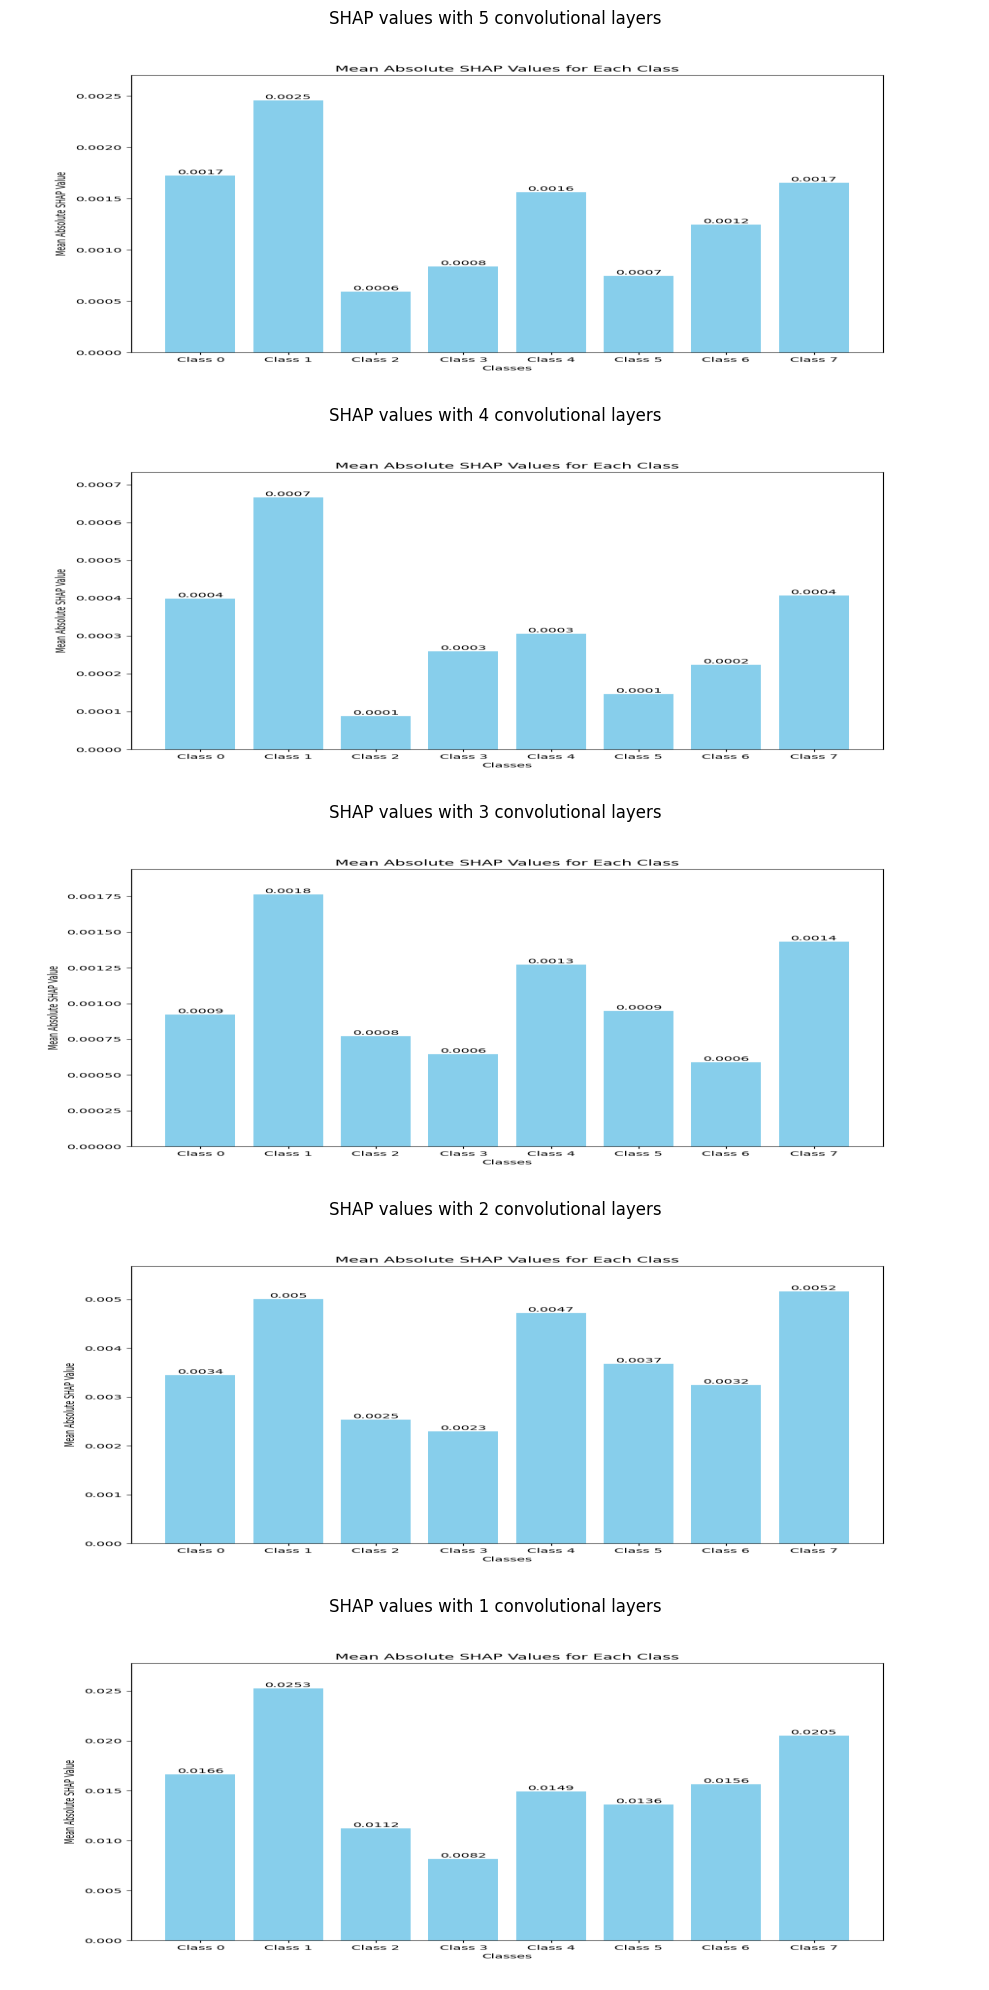

[{'k': 0, 'shap_buffers': [<_io.BytesIO object at 0x75de9ed008b0>]}, {'k': 1, 'shap_buffers': [<_io.BytesIO object at 0x75de7c87e5c0>]}, {'k': 2, 'shap_buffers': [<_io.BytesIO object at 0x75de857516c0>]}, {'k': 3, 'shap_buffers': [<_io.BytesIO object at 0x75de84707290>]}, {'k': 4, 'shap_buffers': [<_io.BytesIO object at 0x75de779816c0>]}]


In [113]:
results = XAINT.iterate_k_and_evaluate(model, max_k=5, train_loader=train_loader, test_loader=test_loader)
print(results)

Evaluating models:   0%|                                                   | 0/5 [00:00<?, ?model/s]

Test Loss: 0.7694, Test Accuracy: 75.69%


/home/andrea-coppari/XAI/XAINT/venv/lib/python3.12/site-packages/shap/explainers/_deep/deep_pytorch.py:243: UserWarning: unrecognized nn.Module: Identity
  warnings.warn(f'unrecognized nn.Module: {module_type}')
Evaluating models:  20%|########6                                  | 1/5 [00:32<02:08, 32.13s/model]

Test Loss: 2.0989, Test Accuracy: 15.97%


Evaluating models:  40%|#################2                         | 2/5 [01:06<01:39, 33.30s/model]

Test Loss: 3.4184, Test Accuracy: 12.50%


Evaluating models:  60%|#########################8                 | 3/5 [01:39<01:07, 33.51s/model]

Test Loss: 8.5165, Test Accuracy: 11.11%


Evaluating models:  80%|##################################4        | 4/5 [02:14<00:33, 33.76s/model]

Test Loss: 44.6888, Test Accuracy: 11.11%


Evaluating models: 100%|###########################################| 5/5 [02:46<00:00, 33.32s/model]


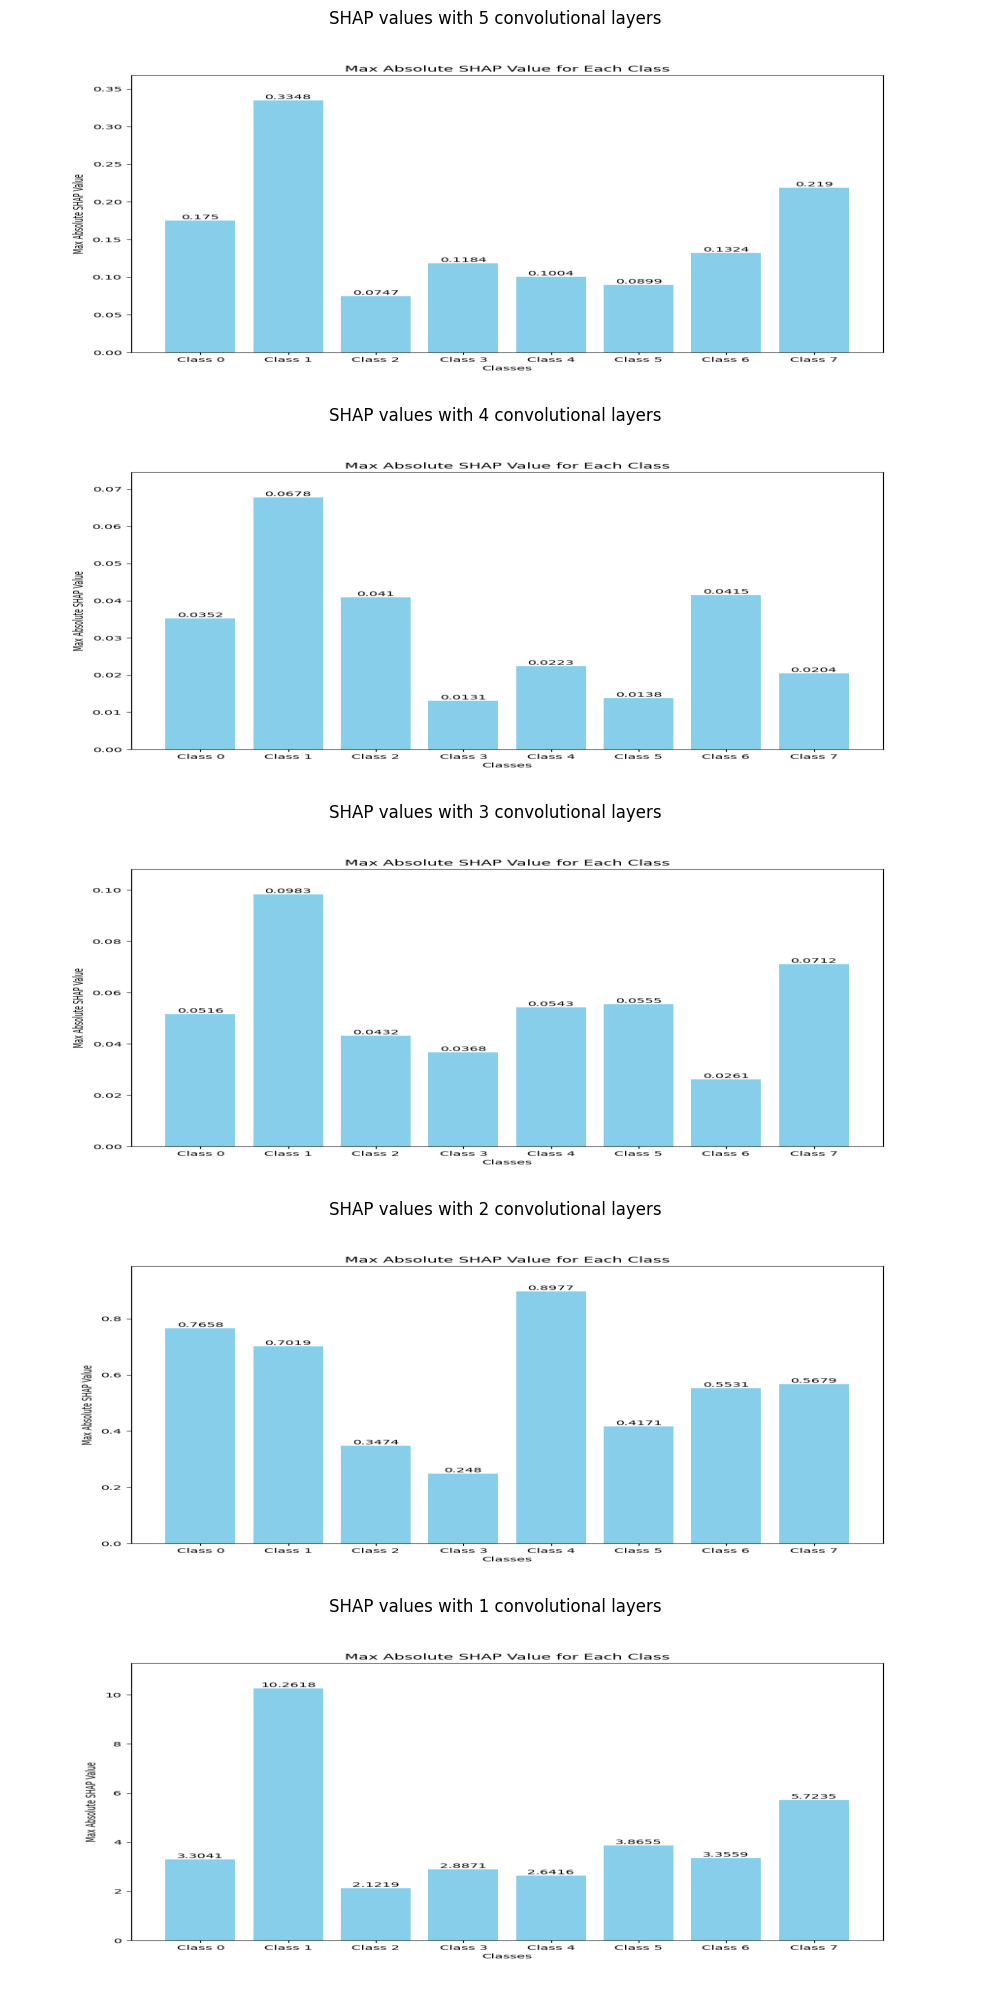

[{'k': 0, 'shap_buffers': [<_io.BytesIO object at 0x75de846c5800>]}, {'k': 1, 'shap_buffers': [<_io.BytesIO object at 0x75de7c668720>]}, {'k': 2, 'shap_buffers': [<_io.BytesIO object at 0x75de7d2fc040>]}, {'k': 3, 'shap_buffers': [<_io.BytesIO object at 0x75de84996f70>]}, {'k': 4, 'shap_buffers': [<_io.BytesIO object at 0x75de7cab9350>]}]


In [111]:
results = XAINT.iterate_k_and_evaluate(model, max_k=5, train_loader=train_loader, test_loader=test_loader)
print(results)